In [1]:
# %reset

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import configparser
import matplotlib.pyplot as plt

from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import evaluation
import visualize

config = configparser.ConfigParser()
config.read('../../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
input_dir = vg_json_export + 'feature_arrays/'
input_dir_raw = vg_json_export + 'raw_feature_arrays/'
output_dir = vg_json_export + 'test_combined_model/'
image_dir = config['PATHS']['vg-images']

colors = preprocessing.basic_colors()

batch_size = 128
num_classes = 11
epochs = 25

set_type = 'dev'

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
    print ('Pfad {path} angelegt'.format(path=output_dir))

Using TensorFlow backend.


In [3]:
# Gezippte Numpy-Archive importieren
bottomup_arrays = np.load(input_dir+'baseline_arrays_bgr_resampled.npz', allow_pickle=True)
topdown_arrays = np.load(input_dir+'type_to_color_resampled.npz', allow_pickle=True)

train_bu_x = bottomup_arrays['train_x']
train_td_x = topdown_arrays['train_x']
train_y = topdown_arrays['train_y']
train_ids = topdown_arrays['train_y'][:,0]

#train_bu_x = pd.DataFrame(train_bu_x, index=train_bu_x[:,0]).loc[train_ids].to_numpy()

test_bu_x = bottomup_arrays['test_x']
test_td_x = topdown_arrays['test_x']
test_y = topdown_arrays['test_y']
test_ids = topdown_arrays['test_x'][:,0]

test_bu_x = pd.DataFrame(test_bu_x, index=test_bu_x[:,0]).loc[test_ids].to_numpy()

dev_bu_x = bottomup_arrays['dev_x']
dev_td_x = topdown_arrays['dev_x']
dev_y = topdown_arrays['dev_y']
dev_ids = topdown_arrays['dev_y'][:,0]

dev_bu_x = pd.DataFrame(dev_bu_x, index=dev_bu_x[:,0]).loc[dev_ids].to_numpy()

In [4]:
print ('Train-IDs identisch:', np.array_equal(train_bu_x[:,0], train_td_x[:,0]))
print ('Test-IDs identisch:', np.array_equal(test_bu_x[:,0], test_td_x[:,0]))
print ('Dev-IDs identisch:', np.array_equal(dev_bu_x[:,0], dev_td_x[:,0]))

Train-IDs identisch: True
Test-IDs identisch: True
Dev-IDs identisch: True


# Embedding

0.3530321440834453


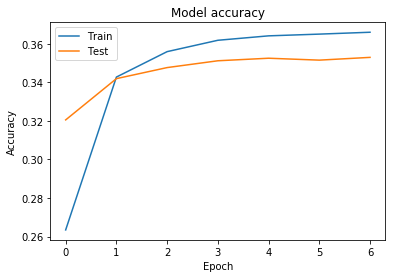

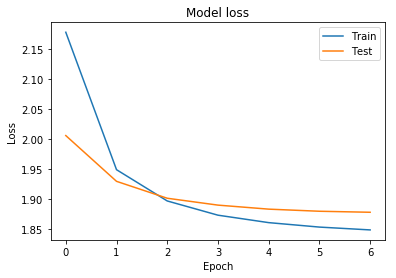

In [6]:
from keras.layers import Input, Dense, Dropout,Embedding,concatenate,Flatten
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop, Adam
from IPython.display import SVG

# Inputs
td_input = Input(shape=(1,), name='td_input')

td_embedding = Embedding(train_td_x[:,1:].shape[1], 6, input_length=1)(td_input)
flatten = Flatten()(td_embedding)

x = Dense(24, activation='relu',name='dense_1')(flatten)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=td_input, outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
#model.summary()

history = model.fit(train_td_x[:,1:].argmax(axis=1), train_y[:,1:],
                    batch_size=batch_size,
                    epochs=7,
                    verbose=0,
                    validation_data=(test_td_x[:,1:].argmax(axis=1), test_y[:,1:]))
score = model.evaluate(test_td_x[:,1:].argmax(axis=1), test_y[:,1:], verbose=0)
print (score[1])

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [9]:
# model.layers[1].get_weights()[0][0]

# Kombinierter Klassifikator

### Embedding ohne Dense Layer

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bu_input (InputLayer)           (None, 512)          0                                            
__________________________________________________________________________________________________
td_input (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
bu_dense_0 (Dense)              (None, 240)          123120      bu_input[0][0]                   
__________________________________________________________________________________________________
td_embedding (Embedding)        (None, 1, 6)         5232        td_input[0][0]              

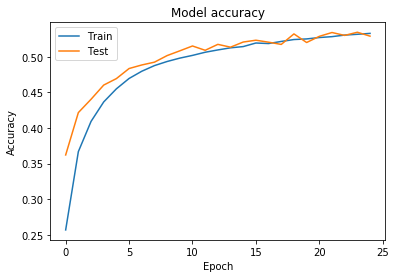

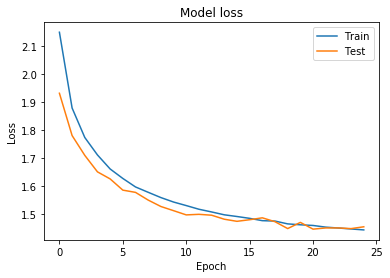

In [7]:
from keras.layers import Input, Dense, Dropout,Embedding,concatenate,Flatten
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop
from IPython.display import SVG


# Inputs
bu_inputs = Input(shape=(train_bu_x.shape[1]-1,), name='bu_input')
td_inputs = Input(shape=(1,), name='td_input')

td_embedding = Embedding(train_td_x[:,1:].shape[1], 6, input_length=1, name='td_embedding')(td_inputs)
flatten = Flatten(name='td_flatten')(td_embedding)

x_bu = Dense(240, activation='relu',name='bu_dense_0')(bu_inputs)
x_bu = Dropout(0.2, name='bu_dropout_0')(x_bu)

conc = concatenate([x_bu, flatten],axis=1, name='bu_td_concat')

x = Dense(24, activation='relu',name='dense_1')(conc)
x = Dropout(0.2, name='dropout_1')(x)

predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=[bu_inputs,td_inputs], outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

SVG(model_to_dot(model,show_shapes=True,show_layer_names=False,rankdir='TB').create(prog='dot', format='svg'))

model.summary()

history = model.fit([train_bu_x[:,1:], train_td_x[:,1:].argmax(axis=1)], train_y[:,1:],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=([dev_bu_x[:,1:], dev_td_x[:,1:].argmax(axis=1)], dev_y[:,1:]))
score = model.evaluate([dev_bu_x[:,1:], dev_td_x[:,1:].argmax(axis=1)], dev_y[:,1:], verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Merge nach BU-Input / TD-Embedding

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
td_input (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
td_embedding (Embedding)        (None, 1, 6)         5232        td_input[0][0]                   
__________________________________________________________________________________________________
bu_input (InputLayer)           (None, 512)          0                                            
__________________________________________________________________________________________________
td_flatten (Flatten)            (None, 6)            0           td_embedding[0][0]               
__________________________________________________________________________________________________
bu_td_conc

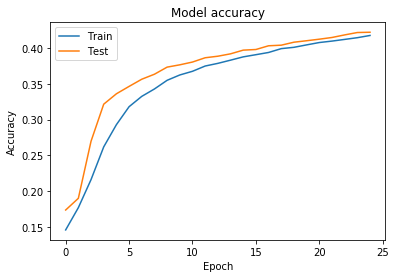

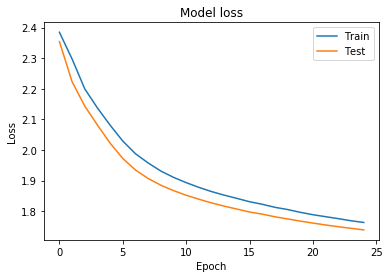

In [118]:
from keras.layers import Input, Dense, Dropout,Embedding,concatenate,Flatten
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop
from IPython.display import SVG


# Inputs
bu_inputs = Input(shape=(train_bu_x.shape[1]-1,), name='bu_input')
td_inputs = Input(shape=(1,), name='td_input')

td_embedding = Embedding(train_td_x[:,1:].shape[1], 6, input_length=1, name='td_embedding')(td_inputs)
flatten = Flatten(name='td_flatten')(td_embedding)

conc = concatenate([bu_inputs, flatten],axis=1, name='bu_td_concat')

x = Dense(240, activation='relu')(conc)
x = Dropout(0.2)(x)

x = Dense(24, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes, activation='softmax', name='predictions')(x)


model = Model(inputs=[bu_inputs,td_inputs], outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.summary()

history = model.fit([train_bu_x[:,1:], train_td_x[:,1:].argmax(axis=1)], train_y[:,1:],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=([dev_bu_x[:,1:], dev_td_x[:,1:].argmax(axis=1)], dev_y[:,1:]))
score = model.evaluate([dev_bu_x[:,1:], dev_td_x[:,1:].argmax(axis=1)], dev_y[:,1:], verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Embeddings extrahieren

In [22]:
model_input_dir = vg_json_export+'models/'
output_dir = vg_json_export+'prediction_arrays/'

model_file = 'earlyfusion_model.h5'
model = load_model(model_input_dir+model_file)
model.summary()

embeddings = model.layers[1].get_weights()[0]
embeddings.shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
td_input (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
td_embedding (Embedding)        (None, 1, 6)         5232        td_input[0][0]                   
__________________________________________________________________________________________________
bu_input (InputLayer)           (None, 512)          0                                            
__________________________________________________________________________________________________
td_flatten (Flatten)            (None, 6)            0           td_embedding[0][0]               
__________________________________________________________________________________________________
bu_td_conc

(872, 6)

In [30]:
raw_td_arrays = np.load(vg_json_export+'raw_feature_arrays/type_to_color.npz')
raw_td_train = raw_td_arrays['train_x']
#np.concatenate((raw_td_train[:,0].reshape(-1,1), raw_td_train[:,1:].argmax(axis=1).reshape(-1,1)), axis=1)

In [67]:
all_obj = pd.read_csv(vg_json_export+'extracted_data/all_objects.csv', index_col=0)
objects = pd.get_dummies(
            all_obj.loc[raw_td_train[:,0]].object_name
            ).columns
objects = {i:objects[i] for i in range(len(objects))}

In [98]:
bottomup_arrays = np.load(vg_json_export+'prediction_arrays/results_perceptron_bgr.npz')
# Prediction-Arrays aus importierten Numpy-Dateien
bottomup_predict = bottomup_arrays['predict_test_y']

# IDs zu Prediction-Arrays hinzufügen
ids = bottomup_arrays['test_y'][:,0:1]
bottomup_predict = np.append(ids, bottomup_predict, axis=1)

# Frequente Objekte + CDOs + CNOs:
frequent_objects, color_diagnostic_objects, color_biased_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100, num_cnos=100, min_num=100)
# DataFrame mit Objekten aus Prediction-Arrays
pred_obj = all_obj.loc[bottomup_predict[:,0]]
# DataFrames für CDOs, CBOs und CNOs
cd_obj = pred_obj.loc[pred_obj.object_name.isin(color_diagnostic_objects.keys())]
cb_obj = pred_obj.loc[pred_obj.object_name.isin(color_biased_objects)]
cn_obj = pred_obj.loc[pred_obj.object_name.isin(color_neutral_objects)]

cdo_name_list = list(cd_obj.object_name.unique())
cbo_name_list = list(cb_obj.object_name.unique())
cno_name_list = list(cn_obj.object_name.unique())

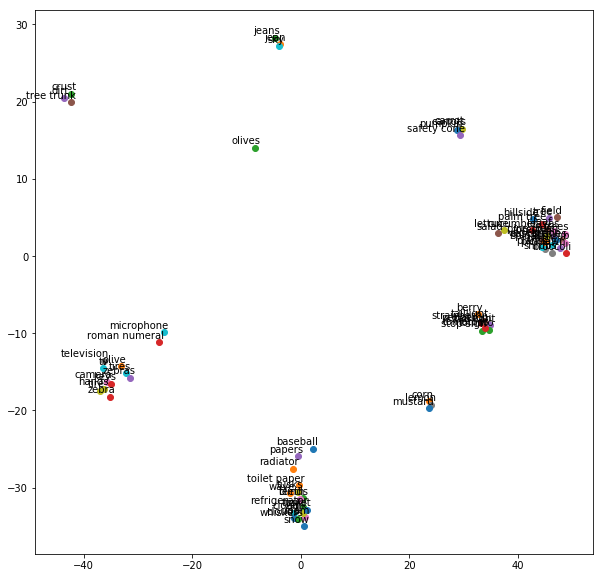

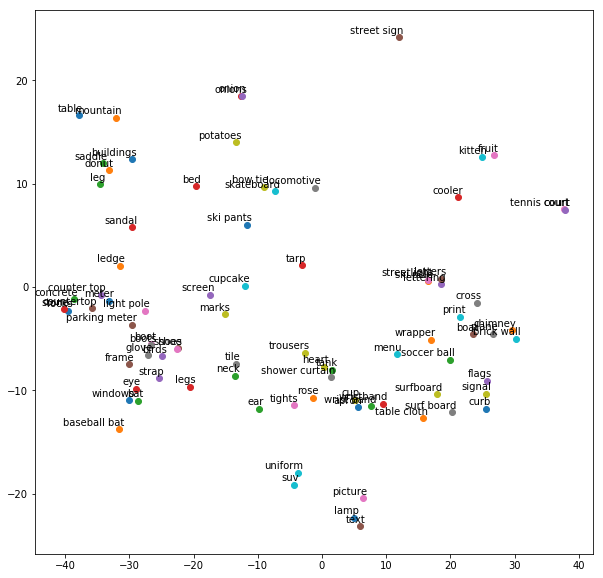

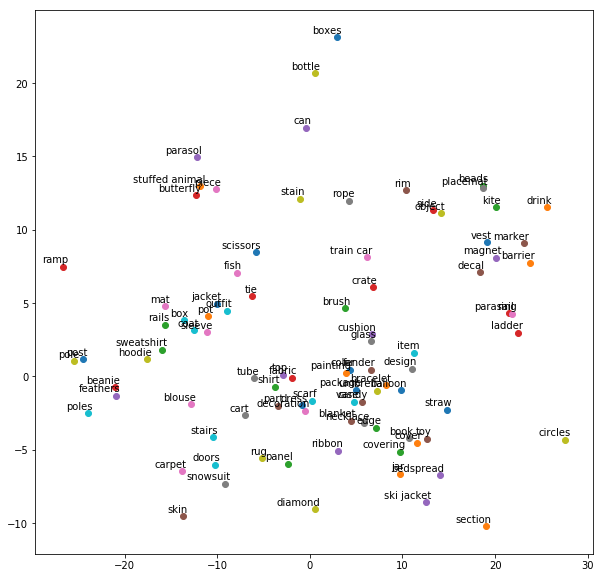

In [117]:
from sklearn.manifold import TSNE
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000, random_state=123)
new_values = tsne_model.fit_transform(embeddings)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
# plotten

for l in [cdo_name_list, cbo_name_list, cno_name_list]:
    key_list = list()
    for item  in objects.items():
        if item[1] in l:
            key_list.append(item[0])

    plt.figure(figsize=(10,10)) 
    for i in range(len(x)):
        if i in key_list:
            plt.scatter(x[i],y[i])
            plt.annotate(objects[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
    plt.show()